* [1.Load Data From CSV File](#ld)
* [2.Build a pipeline](#bp)
* [3.Idée pour choisir le meilleur modèle](#ic)
* [4.Modèles de machine learning choisis](#mml)


In [2]:
#!pip install xgboost

In [3]:
#!pip install lightgbm 

In [4]:
#!pip install shap

In [5]:
#!pip install --index-url https://test.pypi.org/simple/ -U julearn --pre

In [6]:
#!pip install hyperopt

In [7]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns

import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from  xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import shap

import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,StratifiedGroupKFold
from sklearn.metrics import mean_absolute_error,r2_score
from time import time
from julearn import run_cross_validation
from julearn.utils import configure_logging
from julearn.model_selection import StratifiedGroupsKFold
from statistics import mean
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials

from sklearn.metrics import mean_squared_error


In [8]:
############Fonction affichant les variables corrélés en fixant un seuil
def f_strong_correlation(threshold_up ,df2):
    #threshold_up = 0.7
    corr_pairs = df2.corr().unstack().sort_values(kind="quicksort")
    strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold_up)])
               .reset_index().rename(columns={0:'corr_coeff'}))
    strong_corr = strong_corr[(strong_corr.index%2 == 0) & 
                          (strong_corr['level_0'] != strong_corr['level_1'])]
    strong_corr.sort_values('corr_coeff', ascending=False)
    return strong_corr
##################"fonction pour afficher les performances d'un modèle
def f_performance(pip):
    #pip.fit(X_train,y_train)
  
    
    print('******************')
    #Check MSE and RMSE

    y_pred = pip.predict(X_test)
    print(f'MSE : {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
    print(f'R2 : {r2_score(y_test, y_pred):.3f}')
##################################################
def f_coeff(pip):
    # Putting together the coefficient and their corresponding variable names
    
    df_coefficient = pd.DataFrame()
    df_coefficient["Columns"] = feature_after_transformer(preprocessor)
    df_coefficient['Estimated Coefficient '] = pd.Series(pip.named_steps['model'].coef_.flatten())
    return df_coefficient
    #print(lreg_coefficient)
####################""
def feature_after_transformer(preprocessor):
    tx = preprocessor.get_params()['transformers']
    feature_names = []
    for name,transformer,features in tx:
        try:
            Var = preprocessor.named_transformers_[name].get_feature_names_out().tolist()
        except AttributeError:
            Var = features
        feature_names = feature_names + Var

    return feature_names
#####fonction pour sauvegarder le modele/gridsearch
def save_model_grid(object_to_save,filename,object_type):
    if object_type=='model':
        ch=filename+'.joblib'
    elif object_type=='gridsearch':
        ch=filename+'.pkl'
    joblib.dump(object_to_save,ch)

#####fonction pour charger le modele/gridsearch
def load_model_grid(ch):
    loaded_object = joblib.load(ch)
    return loaded_model
########fonction pour extraire les données d'un pipeline apres pretraitement
def preprocessed_data(X,pip):
    X_encoded = pip['preprocessor'].fit_transform(X)
    return X_encoded
#### plot coeff
def f_plot_coeff(pip_reg):
    # plotting the coefficient score
    

    fig, ax = plt.subplots(figsize =(25, 10))
 
    color =['tab:gray', 'tab:blue', 'tab:orange',
            'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
            'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
            'tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
    
    df_coefficient=f_coeff(pip_reg)
    ax.bar(df_coefficient["Columns"],
    df_coefficient['Estimated Coefficient '],
       color=color
           )

    ax.spines['bottom'].set_position('zero')
 
    plt.style.use('ggplot')
    plt.xticks(rotation=30, ha='right')
    plt.show()


### 1.Load Data From CSV File<a class="anchor" id="ld"></a>

In [9]:
#df = pd.read_csv('prepared_data.csv', sep='\t')
df = pd.read_csv('df_quantile.csv',sep='\t')


In [10]:
df.shape

(1541, 17)

In [11]:
columns=list(df.columns)
columns

['OSEBuildingID',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)',
 'BuildingType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'tranche_date',
 'BuildingAge',
 'groups_neighborhood',
 'groups_PrimaryPropertyType',
 'GFABuildingRate']

In [12]:
target1='TotalGHGEmissions'
target2='SiteEnergyUse(kBtu)'

In [13]:
df.columns

Index(['OSEBuildingID', '%NaturalGas(kBtu)', '%SteamUse(kBtu)', 'BuildingType',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'tranche_date',
       'BuildingAge', 'groups_neighborhood', 'groups_PrimaryPropertyType',
       'GFABuildingRate'],
      dtype='object')

In [14]:
f_strong_correlation(0.7 ,df)

level_0                level_1  corr_coeff
0     PropertyGFATotal    SiteEnergyUse(kBtu)    0.716380
2  SiteEnergyUse(kBtu)     SourceEUI(kBtu/sf)    0.732017
4    TotalGHGEmissions  GHGEmissionsIntensity    0.756458
6  SiteEnergyUse(kBtu)      TotalGHGEmissions    0.885268

In [15]:
#ici on élimine 'OSEBuildingID' ,GHGEmissionsIntensity(kBtu/sf) et 'SiteEnergyUse(kBtu)'(target2)
cols=list(set(columns)-set(['OSEBuildingID','GHGEmissionsIntensity',target2]))
cols

['NumberofBuildings',
 'SourceEUI(kBtu/sf)',
 'groups_PrimaryPropertyType',
 'BuildingType',
 'groups_neighborhood',
 'BuildingAge',
 '%NaturalGas(kBtu)',
 'GFABuildingRate',
 'TotalGHGEmissions',
 'ENERGYSTARScore',
 'NumberofFloors',
 'PropertyGFATotal',
 'tranche_date',
 '%SteamUse(kBtu)']

In [16]:
df=df[cols]

In [17]:
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
print(numercial_cols)

['NumberofBuildings', 'SourceEUI(kBtu/sf)', 'BuildingAge', '%NaturalGas(kBtu)', 'GFABuildingRate', 'TotalGHGEmissions', 'ENERGYSTARScore', 'NumberofFloors', 'PropertyGFATotal', '%SteamUse(kBtu)']


In [18]:
categorical_cols = [col for col in df.columns if df[col].dtype=="O"]
print(categorical_cols)

['groups_PrimaryPropertyType', 'BuildingType', 'groups_neighborhood', 'tranche_date']


In [19]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

In [20]:
df['groups_neighborhood'].unique()

array(['Various', 'North', 'Central', 'South'], dtype=object)

In [21]:
df['tranche_date'].unique()

array(['tranche_date1', 'tranche_date3', 'tranche_date2', 'tranche_date4'],
      dtype=object)

In [22]:
df['groups_PrimaryPropertyType'].unique()

array(['Various', 'Commerce', 'Health'], dtype=object)

In [23]:
df.shape

(1541, 14)

In [24]:
numercial_cols_for_transformer=list(set(numercial_cols)-set([target1]))

In [25]:
numercial_cols_for_transformer

['NumberofBuildings',
 'SourceEUI(kBtu/sf)',
 'GFABuildingRate',
 'ENERGYSTARScore',
 'NumberofFloors',
 'PropertyGFATotal',
 'BuildingAge',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)']

In [26]:
font = {
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

## 2.Build a pipeline <a class="anchor" id="bp"></a>

In [27]:
# Create pipelines for numerical and categorical features
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore",drop='first')
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [28]:
feature_after_transformer(preprocessor)

['NumberofBuildings',
 'SourceEUI(kBtu/sf)',
 'GFABuildingRate',
 'ENERGYSTARScore',
 'NumberofFloors',
 'PropertyGFATotal',
 'BuildingAge',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)',
 'groups_PrimaryPropertyType',
 'BuildingType',
 'groups_neighborhood',
 'tranche_date']

In [29]:
y=df[[target1]]


In [30]:
y= StandardScaler().fit_transform(y)
features=list(set(cols)-set([target1]))
X=df[features]


In [31]:
features

['NumberofBuildings',
 'SourceEUI(kBtu/sf)',
 '%NaturalGas(kBtu)',
 'GFABuildingRate',
 'ENERGYSTARScore',
 'tranche_date',
 'NumberofFloors',
 'PropertyGFATotal',
 'BuildingType',
 'groups_PrimaryPropertyType',
 'groups_neighborhood',
 'BuildingAge',
 '%SteamUse(kBtu)']

#### Continuous target stratification

In [32]:
import math
num_splits = 10

num_bins = math.floor(len(df) / num_splits)  # num of bins to be created

num_bins
bins_on = y  # variable to be used for stratification
bins_on
qc = pd.cut(bins_on.flatten(), num_bins)  # divides data in bins
df['bins'] = qc.codes
groups = 'bins'
y_binned=df['bins']


In [33]:
num_bins

154

In [34]:
#df.loc[:,'bins'].value_counts()

In [35]:
print(df.groupby(['bins']).size())

bins
0      1
28     1
31     1
34     1
36     2
      ..
116    2
118    1
119    1
120    2
153    1
Length: 88, dtype: int64


In [36]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
#The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=0)

In [37]:
df2 = df[df['bins'].isin(df['bins'].value_counts()[df['bins'].value_counts()>2].index)]

In [38]:
df2.loc[:,'bins'].value_counts()

76     42
75     42
79     42
74     41
78     41
       ..
108     4
46      4
109     4
44      4
114     3
Name: bins, Length: 69, dtype: int64

In [39]:
#df.shape #(1541, 16)
#df2.shape#(1514, 16)
y2_binned=df2['bins']
X2=df2[features]
y2=df2[target1]

In [40]:
print(df2.groupby(['bins']).size())

bins
42     4
44     4
45     6
46     4
47     7
      ..
107    6
108    4
109    4
111    5
114    3
Length: 69, dtype: int64


#### Division des données

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, stratify=y2_binned,random_state=3)

## 3.Idée pour choisir le meilleur modèle <a class="anchor" id="ic"></a>

In [42]:
regressors = [DummyRegressor(strategy="median",constant=None,quantile=0.5),
              LinearRegression(fit_intercept=True,normalize=True,copy_X=True),
              Ridge(alpha=5,solver='auto',fit_intercept=True),
              Lasso(tol=1e-3,selection='random',fit_intercept=True),
              ElasticNet(tol=1e-3,selection='random',fit_intercept=True),
              RandomForestRegressor(n_estimators=100,max_leaf_nodes=1000,criterion='squared_error'),
              SVR(kernel='rbf',degree=3,gamma='scale'),
              LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1),
              XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 100)
              ]

In [43]:
test_mse=[]
test_rmse=[]
test_r2=[]
train_r2=[]
for model in regressors:
    start = time()
    #select=SelectKBest(score_func=f_regression,k=8)
    #pip = Pipeline(steps=[("preprocessor", preprocessor),("selector",select),("model", model)])
    pip = Pipeline(steps=[("preprocessor", preprocessor),("model", model)])

    pip.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    scores = cross_val_score(pip, X_train, y_train, cv=10,scoring='r2')
    print("\tTest Mean squared error:", mean_squared_error(y_test, y_pred))
    test_mse.append(mean_squared_error(y_test, y_pred))
    print("\tTest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tTest R2 score:", r2_score(y_test, y_pred))
    test_r2.append(r2_score(y_test, y_pred))
    print("\tTraining R2 score (Cross validation):", mean(scores))
    train_r2.append(mean(scores))
    print()


DummyRegressor(quantile=0.5, strategy='median')
	Training time: 0.031s
	Prediction time: 0.009s
	Test Mean squared error: 0.8925632810778623
	Test RMSE: 0.9447556726889034
	Test R2 score: -0.0003521170237161808
	Training R2 score (Cross validation): -0.009198362510260604

LinearRegression(normalize=True)
	Training time: 0.059s
	Prediction time: 0.011s
	Test Mean squared error: 0.136179614587147
	Test RMSE: 0.3690252221558128
	Test R2 score: 0.8473748935949759
	Training R2 score (Cross validation): 0.8357460307000515

Ridge(alpha=5)
	Training time: 0.031s
	Prediction time: 0.007s
	Test Mean squared error: 0.1353682988123594
	Test RMSE: 0.367924311254855
	Test R2 score: 0.8482841864934059
	Training R2 score (Cross validation): 0.8364687764187048

Lasso(selection='random', tol=0.001)
	Training time: 0.056s
	Prediction time: 0.008s
	Test Mean squared error: 0.8923556528577192
	Test RMSE: 0.9446457816862992
	Test R2 score: -0.00011941494647738082
	Training R2 score (Cross validation): -0.00

In [44]:
regressors

[DummyRegressor(quantile=0.5, strategy='median'),
 LinearRegression(normalize=True),
 Ridge(alpha=5),
 Lasso(selection='random', tol=0.001),
 ElasticNet(selection='random', tol=0.001),
 RandomForestRegressor(max_leaf_nodes=1000),
 SVR(),
 LGBMRegressor(max_depth=1),
 XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
              reg_lambda=1, ...)]

In [45]:
d={'Regressor':regressors,'Test Mean squared error':test_mse,'Test RMSE':test_rmse,'Test R2 score':test_r2,
  'Training R2 score (Cross validation)':train_r2}

pd.set_option('display.colheader_justify', 'center')
res1=pd.DataFrame(d)
res1

Regressor                       Test Mean squared error  \
0    DummyRegressor(quantile=0.5, strategy='median')         0.892563           
1                   LinearRegression(normalize=True)         0.136180           
2                                     Ridge(alpha=5)         0.135368           
3               Lasso(selection='random', tol=0.001)         0.892356           
4          ElasticNet(selection='random', tol=0.001)         0.881584           
5  (DecisionTreeRegressor(max_features='auto', ma...         0.040812           
6                                              SVR()         0.062611           
7                         LGBMRegressor(max_depth=1)         0.099022           
8  XGBRegressor(base_score=0.5, booster='dart', c...         0.043874           

   Test RMSE  Test R2 score  Training R2 score (Cross validation)  
0  0.944756    -0.000352                  -0.009198                
1  0.369025     0.847375                   0.835746                
2  0.367924     0.848284                   0.836469                
3  0.944646    -0.000119                  -0.008438                
4  0.938927     0.011953                   0.009914                
5  0.202019     0.954260                   0.939784                
6  0.250222     0.929828                   0.918464                
7  0.314677     0.889020                   0.877361                
8  0.209461     0.950828                   0.945662

In [46]:
res1.iloc[5,0]


RandomForestRegressor(max_leaf_nodes=1000)

**Note**
<br>
Dans la suite on va travailler sur les  modèles retenus ayant les 4 premiers meilleurs coefficiet de détermination r2 notamment LinearRegression,Ridge,SVR et LGBMRegressor.

## 4.Modèles de machine learning choisis<a class="anchor" id="mml"></a>

### 4.1.Regression linéaire

In [47]:
#LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, 
#and the targets predicted by the linear approximation.

In [48]:

clf_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression(fit_intercept=True,normalize=False,copy_X=True))]
)
clf_lr.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   '%NaturalGas(kBtu)',
                                                   '%SteamUse(kBtu)']),
                                                 ('cat',
                                                  One

In [49]:
save_model_grid(clf_lr,'regr_pred1','model')

### 4.1.1.Indicateurs de performance

In [50]:
f_performance(clf_lr)

******************
MSE : 0.136
RMSE : 0.369
R2 : 0.847


### 4.1.2.Coéfficients du modèle

In [51]:

clf_lr.named_steps['model'].intercept_

0.17356436182671617

In [52]:
f_coeff(clf_lr)

Columns                Estimated Coefficient 
0                    NumberofBuildings         0.013370       
1                   SourceEUI(kBtu/sf)         0.452335       
2                      GFABuildingRate         0.058437       
3                      ENERGYSTARScore        -0.000624       
4                       NumberofFloors        -0.012030       
5                     PropertyGFATotal         0.491138       
6                          BuildingAge        -0.082001       
7                    %NaturalGas(kBtu)         0.506960       
8                      %SteamUse(kBtu)         0.219591       
9    groups_PrimaryPropertyType_Health         0.140227       
10  groups_PrimaryPropertyType_Various         0.146982       
11         BuildingType_NonResidential        -0.170935       
12     BuildingType_Nonresidential COS         0.018335       
13      BuildingType_SPS-District K-12        -0.132988       
14           groups_neighborhood_North        -0.030875       
15           groups_neighborhood_South        -0.024988       
16         groups_neighborhood_Various        -0.047206       
17          tranche_date_tranche_date2        -0.049699       
18          tranche_date_tranche_date3        -0.143400       
19          tranche_date_tranche_date4        -0.233128

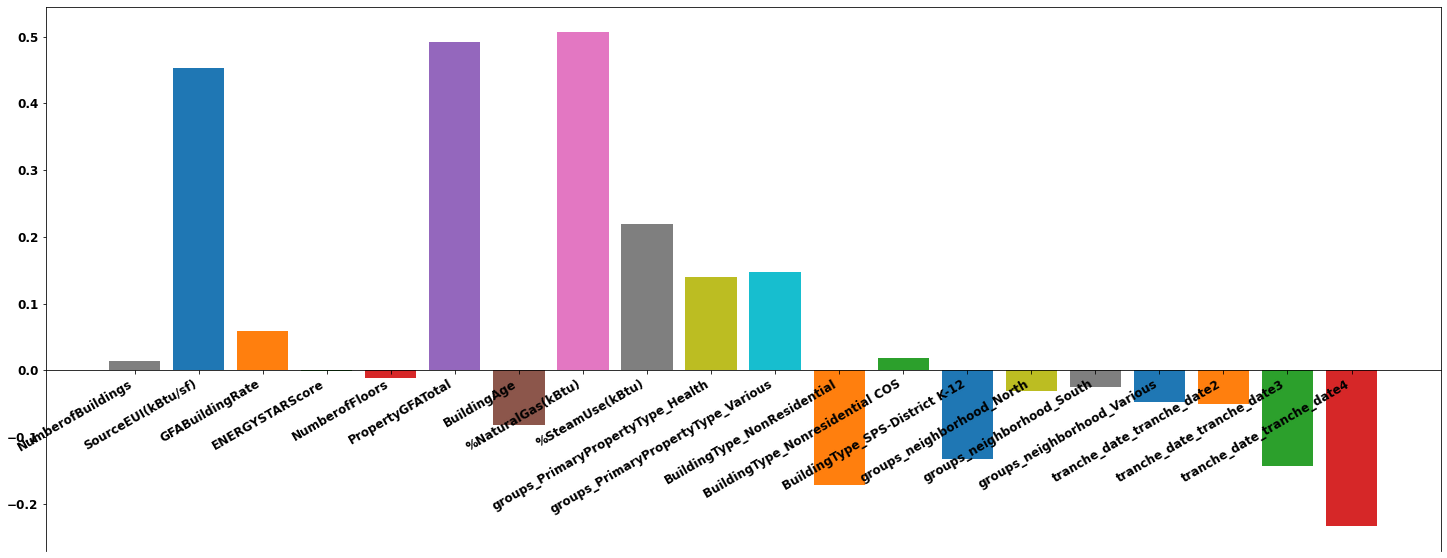

In [53]:
f_plot_coeff(clf_lr)

**Observations**
<br>
On peut remarquer que les features les plus importants sont: 'SourceEUI(kBtu/sf)','%NaturalGas(kBtu)'et 'PropertyGFATotal'

### 4.1.3.Feature importance (shap values)

In [54]:
X_train_encoded=preprocessed_data(X_train,clf_lr)

In [55]:
#shap.initjs()
ex = shap.LinearExplainer(clf_lr['model'], X_train_encoded)
shap_values = ex.shap_values(X_train_encoded)

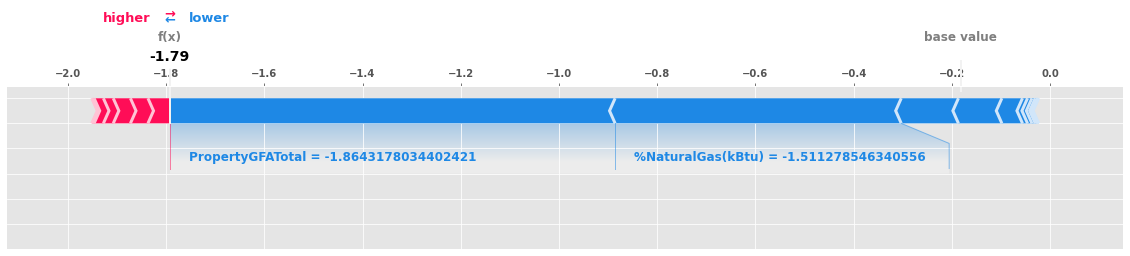

In [56]:
#Observation 1
shap.force_plot(ex.expected_value, shap_values[0,:], X_train_encoded[0,:],feature_names=feature_after_transformer(preprocessor),matplotlib=True)

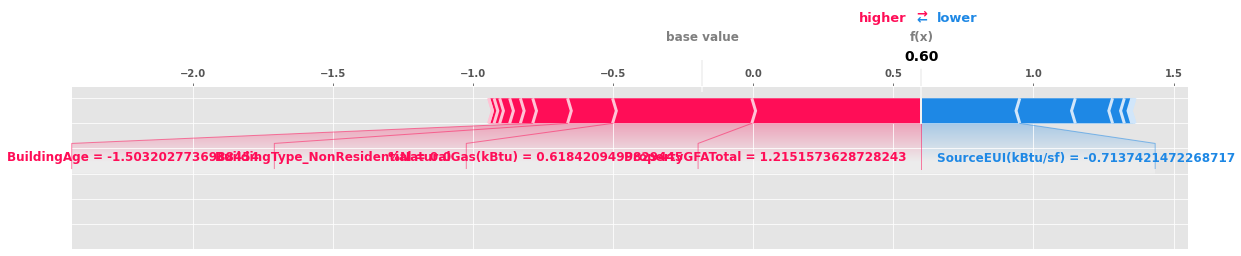

In [57]:
#Observation 2
shap.force_plot(ex.expected_value, shap_values[1,:], X_train_encoded[1,:],feature_names=feature_after_transformer(preprocessor),
               matplotlib=True)

In [58]:
#toutes les observations
shap.initjs()
shap.force_plot(ex.expected_value, shap_values, X_train_encoded,feature_names=feature_after_transformer(preprocessor)
               )

**Observations**
<b>
Les valeurs en bleu('SourceEUI(kBtu/sf)','%NaturalGas(kBtu)', '%SteamUse(kBtu)' et 'PropertyGFATotal') peuvent être considérées comme des valeurs ayant une influence positive sur la prédiction, tandis que les valeurs en rouge ont une influence négative sur la prédiction.

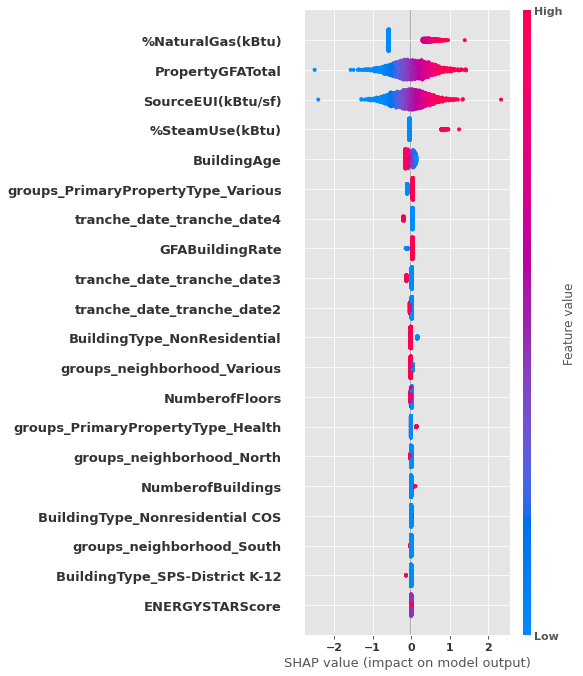

In [59]:
shap.summary_plot(shap_values, X_train_encoded,feature_names=feature_after_transformer(preprocessor))

**Observations**
<br>
La visualization de 'variables’ importance' coincide avec les  coefficients du modèle de la regression linéaire.

In [60]:
print(" mean of R2= %0.2f" % scores.mean())

 mean of R2= 0.95


#### Ajustement des paramètres en utilisant gridsearch

In [61]:
#Paramètres à ajuster
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [62]:

#LinearRegression().get_params().keys()
param_grid = {
    
    "model__fit_intercept": [True, False],
    "model__copy_X": [True, False],
    "model__positive": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search = GridSearchCV(clf_lr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'SourceEUI(kBtu/sf)',
                                                                          'GFABuildingRate',
                                                                          'ENERGYSTARScore',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                      

In [63]:
save_model_grid(grid_search,'grid_search_LR','gridsearch')

In [64]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
 #cv_results

In [65]:
grid_search.best_params_

{'model__copy_X': True,
 'model__fit_intercept': True,
 'model__normalize': True,
 'model__positive': True}

In [66]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.135
RMSE : 0.367
R2 : 0.849


In [67]:
save_model_grid(best_estim,'best_LR','model')


**Observations**
<br>

pas bcp de paramètre avec la regression linéaire regardons la regression polynomial

In [68]:
numeric_transformer_pol = Pipeline(
    steps=[("scaler", StandardScaler()),('poly', PolynomialFeatures(degree=5))]
)

#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor_pol = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pol, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [69]:

clf_pr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())])
clf_pr.fit(X_train,y_train)
f_performance(clf_pr)


******************
MSE : 0.136
RMSE : 0.369
R2 : 0.847


### 4.2.Ridge regression

In [70]:
clf_rr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Ridge(alpha=2,solver='auto',fit_intercept=True))]
)
clf_rr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   '%NaturalGas(kBtu)',
                                                   '%SteamUse(kBtu)']),
                                                 ('cat',
                                                  One

### 4.2.1.Indicateurs de performance

In [71]:
f_performance(clf_rr)

******************
MSE : 0.136
RMSE : 0.368
R2 : 0.848


 ### 4.2.2.Coéfficients du modèle

In [72]:
clf_rr.named_steps['model'].intercept_

0.12002778736270411

In [73]:
f_coeff(clf_rr)


Columns                Estimated Coefficient 
0                    NumberofBuildings         0.015316       
1                   SourceEUI(kBtu/sf)         0.451905       
2                      GFABuildingRate         0.057990       
3                      ENERGYSTARScore        -0.001255       
4                       NumberofFloors        -0.011439       
5                     PropertyGFATotal         0.489638       
6                          BuildingAge        -0.065602       
7                    %NaturalGas(kBtu)         0.506163       
8                      %SteamUse(kBtu)         0.219771       
9    groups_PrimaryPropertyType_Health         0.132545       
10  groups_PrimaryPropertyType_Various         0.143507       
11         BuildingType_NonResidential        -0.140840       
12     BuildingType_Nonresidential COS         0.047005       
13      BuildingType_SPS-District K-12        -0.080455       
14           groups_neighborhood_North        -0.025634       
15           groups_neighborhood_South        -0.018602       
16         groups_neighborhood_Various        -0.042555       
17          tranche_date_tranche_date2        -0.026601       
18          tranche_date_tranche_date3        -0.106634       
19          tranche_date_tranche_date4        -0.185731

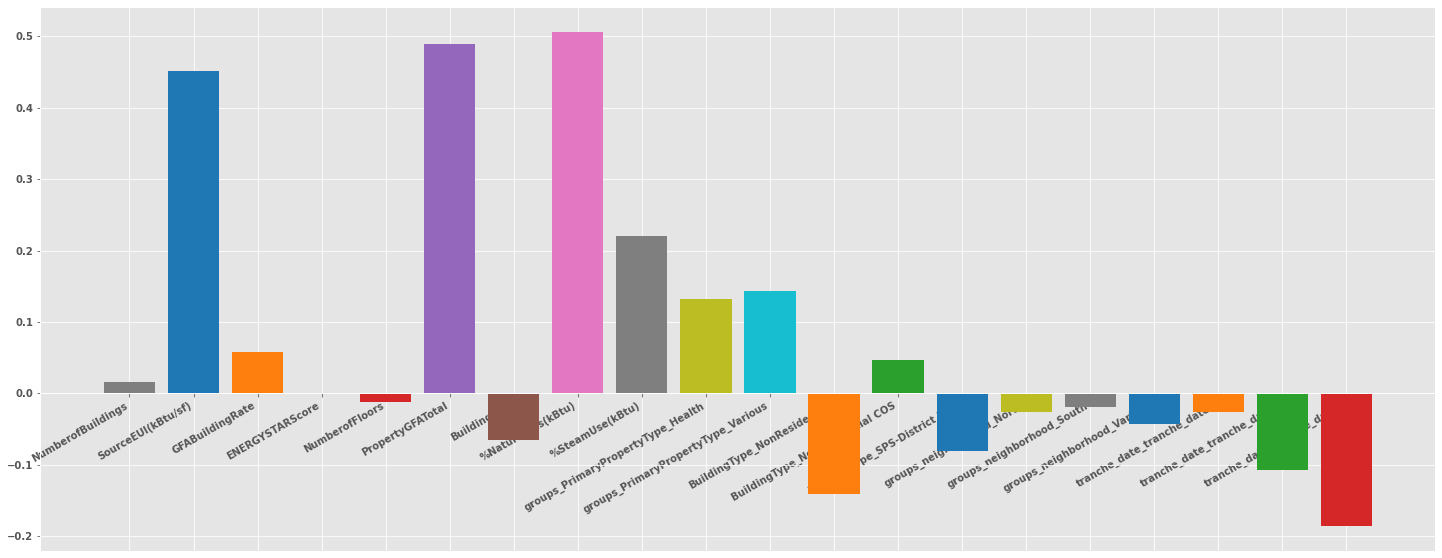

In [74]:
f_plot_coeff(clf_rr)

In [75]:


ex = shap.LinearExplainer(clf_rr['model'], X_train_encoded)
shap_values = ex.shap_values(X_train_encoded)

In [76]:
#toutes les observations
shap.initjs()
shap.force_plot(ex.expected_value, shap_values, X_train_encoded,feature_names=feature_after_transformer(preprocessor))

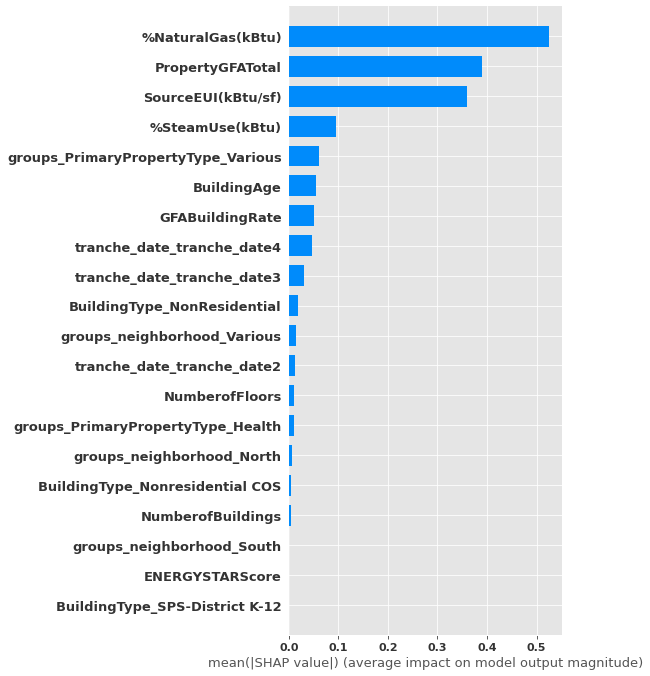

In [77]:

shap.summary_plot(shap_values, X_train_encoded, plot_type='bar',feature_names=feature_after_transformer(preprocessor))

**Observations**
<br>
Pareil pour la regression linéaire,
on peut remarquer que les features les plus importants sont: 'GHGEmissionsIntensity','BuildingType_Campus' et 'PropertyGFATotal

### 4.2.3.Optimisation du modèle

#### Ajustement des paramètres 

In [78]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

In [79]:
#{'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [80]:
param_grid = {
    
    "model__alpha": [1,0.1,0.01,0.001,0.0001,0,5,10],
    "model__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    "model__fit_intercept": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search_clf_rr = GridSearchCV(clf_rr, param_grid, cv=10)
grid_search_clf_rr.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'SourceEUI(kBtu/sf)',
                                                                          'GFABuildingRate',
                                                                          'ENERGYSTARScore',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                      

In [81]:
save_model_grid(grid_search_clf_rr,'gridsearch_RR','gridsearch')

In [82]:
cv_results = pd.DataFrame(grid_search_clf_rr.cv_results_)
#cv_results


In [83]:
grid_search_clf_rr.best_params_


{'model__alpha': 10,
 'model__fit_intercept': False,
 'model__normalize': True,
 'model__solver': 'sparse_cg'}

In [84]:
best_estim=grid_search_clf_rr.best_estimator_
f_performance(best_estim)

******************
MSE : 0.135
RMSE : 0.368
R2 : 0.849


In [85]:
save_model_grid(best_estim,'best_RR','model')

##### 

### 4.3.SVR

In [86]:
clf_svr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", SVR(kernel='rbf',degree=3,gamma='scale'))]
)
clf_svr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   '%NaturalGas(kBtu)',
                                                   '%SteamUse(kBtu)']),
                                                 ('cat',
                                                  One

### 4.3.1.Indicateurs de performance

In [87]:
f_performance(clf_svr)

******************
MSE : 0.063
RMSE : 0.250
R2 : 0.930


### 4.3.2.Coefficients du modèle

In [88]:

clf_svr.named_steps['model'].intercept_

array([0.53285905])

In [89]:
#clf_svr.n_features_in_

In [90]:
#clf_svr.feature_names_in_

### 4.3.3.Optimisation du modèle

#### Cross validation

In [91]:
scores = cross_val_score(clf_svr, X, y, cv=10,scoring='r2')#Ajustement-des-param%C3%A8trese(clf_svr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

array([0.71943143, 0.89267088, 0.90373523, 0.90742137, 0.92225015,
       0.89152569, 0.93075094, 0.93432025, 0.94469224, 0.90630792])

In [92]:
print(" mean of  R2= %0.2f" % scores.mean())

 mean of  R2= 0.90


#### Ajustement des paramètres

In [93]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [102]:
param_grid = {
    
    "model__C": [1,0.1,0.01,0.001,0.0001,0.00001,0.00001,2,3,4,5,10],
    "model__epsilon": [0.0001, 0.001, 0.1, 1, 0.005, 0.0009],
    #"model__kernel": [True, False],
    #"model__gamma": [True, False],
    
}

grid_search_svr = GridSearchCV(clf_svr, param_grid, cv=10)
grid_search_svr.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'SourceEUI(kBtu/sf)',
                                                                          'GFABuildingRate',
                                                                          'ENERGYSTARScore',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                      

In [103]:
save_model_grid(grid_search_svr,'gridsearch_svr','gridsearch')

In [105]:
cv_results = pd.DataFrame(grid_search_svr.cv_results_)
#cv_results

In [106]:
grid_search_svr.best_params_

{'model__C': 10, 'model__epsilon': 0.005}

In [107]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.046
RMSE : 0.213
R2 : 0.949


In [108]:
save_model_grid(best_estim,'best_SVR','model')

In [150]:

#best_model_svr = grid_search_svr.best_estimator_['model'].fit(X_train_encoded, y_train)
#ex = shap.Explainer(best_model_svr.predict, X_train_encoded)
#shap_values = ex(X_train_encoded)



#shap.summary_plot(shap_values, X_train_encoded,feature_names=feature_after_transformer(preprocessor))

### 4.4.LGBMRegressor

In [110]:
clf_lgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1))]
)
clf_lgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   '%NaturalGas(kBtu)',
                                                   '%SteamUse(kBtu)']),
                                                 ('cat',
                                                  One

### 4.4.1.Indicateurs de performance

In [111]:
f_performance(clf_lgb)

******************
MSE : 0.099
RMSE : 0.315
R2 : 0.889


### 4.4.2.Optimisation du modèle

In [ ]:
#### Cross validation

#### Ajustement des paramètres

In [ ]:
list(clf_lgb.get_params().keys())

In [ ]:
param_grid = {
    
    "model__max_depth": [5,10,20,15,30],
    "model__num_leaves": [150,50,10,20,5,100],
     "model__boosting_type": ['gbdt', 'rbf','dart','goss'],
    "model__learning_rate": [0.1, 0.01,1,0.5,0.6,0.7,0.4],
    
}

grid_search_lgb = GridSearchCV(clf_lgb, param_grid, cv=10)
grid_search_lgb.fit(X_train,y_train)

In [ ]:
cv_results = pd.DataFrame(grid_search_lgb.cv_results_)
#cv_results

In [ ]:
save_model_grid(grid_search_lgb,'gridsearch_lgb','gridsearch')

In [151]:
grid_search_lgb.best_params_

{'model__boosting_type': 'dart',
 'model__learning_rate': 0.4,
 'model__max_depth': 5,
 'model__num_leaves': 10}

In [152]:
best_estim_lgb=grid_search_lgb.best_estimator_
f_performance(best_estim_lgb)

******************
MSE : 0.031
RMSE : 0.176
R2 : 0.965


In [ ]:
save_model_grid(best_estim_lgb,'best_LGBM','model')

## 4.5.RandomForestRegressor

In [116]:
clf_rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'))]
)
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   '%NaturalGas(kBtu)',
                                                   '%SteamUse(kBtu)']),
                                                 ('cat',
                                                  One

In [144]:
scores = cross_val_score(clf_rf, X_train, y_train, cv=5,scoring='r2')#Ajustement-des-param%C3%A8trese(clf_svr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

array([0.93669846, 0.93992105, 0.94061915, 0.94718649, 0.93322805])

### 4.5.1.Indicateurs de performance

In [117]:
f_performance(clf_rf)

******************
MSE : 0.040
RMSE : 0.201
R2 : 0.955


In [118]:
X_train_encoded=preprocessed_data(X_train,clf_rf)

In [119]:
X_train_encoded.shape

(1211, 20)

#### Feature importance

<BarContainer object of 20 artists>

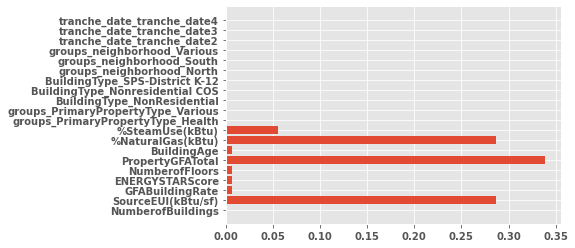

In [120]:
plt.barh(feature_after_transformer(preprocessor), clf_rf['model'].feature_importances_)

In [116]:
import time
start_time = time.time()
importances = clf_rf['model'].feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf['model'].estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.091 seconds


### 4.5.2.Optimisation du modèle

In [36]:
list(clf_rf.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__bootstrap',
 'model__ccp_alpha',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__max_samples',
 'model__min_impurity_decrease',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fracti

In [121]:
param_grid = {
    
    "model__max_leaf_nodes": [1000,5000,100000,None],
    "model__n_estimators": [150,50,10,250,100],
     "model__criterion": ['squared_error', 'absolute_error', 'poisson']
    
}
grid_search_rf = GridSearchCV(clf_rf, param_grid, cv=10)
grid_search_rf.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'SourceEUI(kBtu/sf)',
                                                                          'GFABuildingRate',
                                                                          'ENERGYSTARScore',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                      

In [122]:
save_model_grid(grid_search_rf,'grid_search_RF','gridsearch')

In [124]:
cv_results = pd.DataFrame(grid_search_rf.cv_results_)
#cv_results

In [125]:
grid_search_rf.best_params_

{'model__criterion': 'squared_error',
 'model__max_leaf_nodes': 1000,
 'model__n_estimators': 150}

In [126]:
best_estim_rf=grid_search_rf.best_estimator_
f_performance(best_estim_rf)

******************
MSE : 0.040
RMSE : 0.199
R2 : 0.955


In [127]:
save_model_grid(best_estim_rf,'best_RF','model')

<BarContainer object of 20 artists>

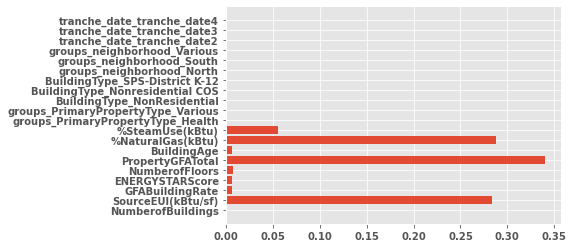

In [136]:
plt.barh(feature_after_transformer(preprocessor), best_estim_rf['model'].feature_importances_)

#### Automated hyerparameter tuning

## 4.6.XGBRegressor

In [128]:
clf_xg = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123))]
)
clf_xg.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   '%NaturalGas(kBtu)',
                                                   '%SteamUse(kBtu)']),
                                                 ('cat',
                                                  One

### 4.6.1.Indicateurs de performance

In [129]:
f_performance(clf_xg)

******************
MSE : 0.055
RMSE : 0.234
R2 : 0.939


### 4.6.2.Optimisation du modèle

In [65]:
list(clf_xg.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__objective',
 'model__base_score',
 'model__booster',
 'model__callbacks',
 'model__colsample_bylevel',
 'model__colsample_bynode',
 'model__colsample_bytree',
 'model__early_stopping_rounds',
 'model__enable_categorical',
 'model__eval_metric',
 'model__gamma',
 '

In [130]:
param = {"booster":"gblinear", "objective":"reg:linear"}
clf_test = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 100))]
)
clf_test.fit(X_train,y_train)
f_performance(clf_test)

******************
MSE : 0.044
RMSE : 0.209
R2 : 0.951


In [132]:
param_grid = {
    
    "model__booster": ['squarederror','gbtree'],
    "model__n_estimators": [150,50,10,20,500,100,5],
    
    "model__max_leaves": [10000, 100000,1000,100],
    "model__learning_rate": [0.3, 0.5,0.1,0.01,0.001]
    
}

grid_search_xg = GridSearchCV(clf_xg, param_grid, cv=10)
grid_search_xg.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'SourceEUI(kBtu/sf)',
                                                                          'GFABuildingRate',
                                                                          'ENERGYSTARScore',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                      

In [139]:
save_model_grid(grid_search_xg,'gridsearch_xg','gridsearch')

In [137]:
cv_results = pd.DataFrame(grid_search_xg.cv_results_)
#cv_results

best_estim_xg=grid_search_xg.best_estimator_
f_performance(best_estim_xg)

******************
MSE : 0.035
RMSE : 0.188
R2 : 0.960


In [140]:
save_model_grid(best_estim_xg,'best_XG','model')

In [135]:
grid_search_xg.best_params_

{'model__booster': 'gbtree',
 'model__learning_rate': 0.1,
 'model__max_leaves': 10000,
 'model__n_estimators': 100}

<BarContainer object of 20 artists>

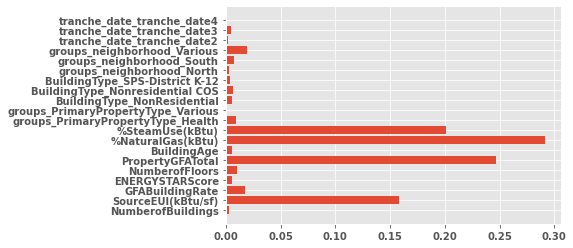

In [138]:
plt.barh(feature_after_transformer(preprocessor), best_estim_xg['model'].feature_importances_)

## 4.6.LGBMRegressor

In [141]:
clf_lgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1))]
)
clf_lgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'BuildingAge',
                                                   '%NaturalGas(kBtu)',
                                                   '%SteamUse(kBtu)']),
                                                 ('cat',
                                                  One

In [142]:
f_performance(clf_lgb)

******************
MSE : 0.099
RMSE : 0.315
R2 : 0.889


In [143]:
param_grid = {
    
    "model__max_depth": [5,10,20,15,30],
    "model__num_leaves": [150,50,10,20,5,100],
     "model__boosting_type": ['gbdt', 'rbf','dart','goss'],
    "model__learning_rate": [0.1, 0.01,1,0.5,0.6,0.7,0.4],
    
}

grid_search_lgb = GridSearchCV(clf_lgb, param_grid, cv=10)
grid_search_lgb.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'SourceEUI(kBtu/sf)',
                                                                          'GFABuildingRate',
                                                                          'ENERGYSTARScore',
                                                                          'NumberofFloors',
                                                                          'PropertyGFATotal',
                                                                      

In [144]:
cv_results = pd.DataFrame(grid_search_lgb.cv_results_)

In [145]:
grid_search_lgb.best_params_

{'model__boosting_type': 'dart',
 'model__learning_rate': 0.4,
 'model__max_depth': 5,
 'model__num_leaves': 10}

In [149]:
save_model_grid(grid_search_lgb,'gridsearch_lgbm','gridsearch')

In [146]:
best_estim_lgb=grid_search_lgb.best_estimator_
f_performance(best_estim_lgb)

******************
MSE : 0.031
RMSE : 0.176
R2 : 0.965


In [148]:
save_model_grid(best_estim_lgb,'best_LGMB','model')

# Impact  de la variable energy star score

In [155]:
X_train.columns

Index(['NumberofBuildings', 'SourceEUI(kBtu/sf)', '%NaturalGas(kBtu)',
       'GFABuildingRate', 'ENERGYSTARScore', 'tranche_date', 'NumberofFloors',
       'PropertyGFATotal', 'BuildingType', 'groups_PrimaryPropertyType',
       'groups_neighborhood', 'BuildingAge', '%SteamUse(kBtu)'],
      dtype='object')

In [156]:
X_test.columns

Index(['NumberofBuildings', 'SourceEUI(kBtu/sf)', '%NaturalGas(kBtu)',
       'GFABuildingRate', 'ENERGYSTARScore', 'tranche_date', 'NumberofFloors',
       'PropertyGFATotal', 'BuildingType', 'groups_PrimaryPropertyType',
       'groups_neighborhood', 'BuildingAge', '%SteamUse(kBtu)'],
      dtype='object')

In [158]:
X_train_without_energyscore=X_train.drop(['ENERGYSTARScore'], axis=1)
X_test_without_energyscore=X_test.drop(['ENERGYSTARScore'], axis=1)

In [165]:
numercial_cols_for_transformer2=list(set(numercial_cols_for_transformer)-set(['ENERGYSTARScore']))
preprocessor2 = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer2),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [163]:
numercial_cols_for_transformer2

['NumberofBuildings',
 'SourceEUI(kBtu/sf)',
 '%NaturalGas(kBtu)',
 'GFABuildingRate',
 'NumberofFloors',
 'PropertyGFATotal',
 'BuildingAge',
 '%SteamUse(kBtu)']

In [168]:
test2_mse=[]
test2_rmse=[]
test2_r2=[]
train2_r2=[]
for model in regressors:
    start = time()
    #select=SelectKBest(score_func=f_regression,k=8)
    #pip = Pipeline(steps=[("preprocessor", preprocessor),("selector",select),("model", model)])
    pip = Pipeline(steps=[("preprocessor", preprocessor2),("model", model)])

    pip.fit(X_train_without_energyscore, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test_without_energyscore)
    predict_time = time()-start    
    #print(model)
    #print("\tTraining time: %0.3fs" % train_time)
    #print("\tPrediction time: %0.3fs" % predict_time)
    scores = cross_val_score(pip, X_train, y_train, cv=10,scoring='r2')
    #print("\tTest Mean squared error:", mean_squared_error(y_test, y_pred))
    test2_mse.append(mean_squared_error(y_test, y_pred))
    #print("\tTest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    test2_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("\tTest R2 score:", r2_score(y_test, y_pred))
    test2_r2.append(r2_score(y_test, y_pred))
    #print("\tTraining R2 score (Cross validation):", mean(scores))
    train2_r2.append(mean(scores))
    #print()
d2={'Regressor':regressors,'Test Mean squared error':test2_mse,'Test RMSE':test2_rmse,'Test R2 score':test2_r2,
  'Training R2 score (Cross validation)':train2_r2}
pd.DataFrame(d2)

Regressor                       Test Mean squared error  \
0    DummyRegressor(quantile=0.5, strategy='median')         0.892563           
1                   LinearRegression(normalize=True)         0.136182           
2                                     Ridge(alpha=5)         0.135371           
3               Lasso(selection='random', tol=0.001)         0.892356           
4          ElasticNet(selection='random', tol=0.001)         0.872520           
5  (DecisionTreeRegressor(max_features='auto', ma...         0.037596           
6                                              SVR()         0.055802           
7                         LGBMRegressor(max_depth=1)         0.099022           
8  XGBRegressor(base_score=0.5, booster='dart', c...         0.039708           

   Test RMSE  Test R2 score  Training R2 score (Cross validation)  
0  0.944756    -0.000352                  -0.009198                
1  0.369029     0.847372                   0.835839                
2  0.367928     0.848281                   0.836557                
3  0.944646    -0.000119                  -0.008438                
4  0.934088     0.022112                   0.011221                
5  0.193897     0.957864                   0.941205                
6  0.236225     0.937459                   0.925629                
7  0.314677     0.889020                   0.877361                
8  0.199269     0.955496                   0.944626